## Załadowanie tekstu i podział między księgi

In [1]:
f = open('AsianReligionsData/Complete_data .txt')
content = f.read()
lines = content.split("\n")
data = []

# wybranie tylko linii z danymi
for i in range(len(lines)):
    if i % 2 == 1:
        data.append(lines[i])

f.close()

len(data)

590

In [3]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()
len(labels)

590

In [4]:
labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
groups = set(labels_general)
groups

{'BookOfEccleasiasticus',
 'BookOfEcclesiastes',
 'BookOfProverb',
 'BookOfWisdom',
 'Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra'}

## Przypisanie średniej emocji każdemu rozdziałowi

In [5]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(tekst):
    filepath = ('AsianReligionsData/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    document = word_tokenize(tekst)
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=range(0, len(document)), columns=emotions)
    for i in range(0, len(document)):
        word = document[i]
        emo_score = emolex_words[emolex_words.word == word]
        if not emo_score.empty:
            for emotion in list(emotions):
                emo_df.at[i, emotion] += emo_score[emotion]

    return emo_df


In [37]:

tmp = text_emotion(data[0])
tmp = tmp.sum()/tmp.shape[0]
average_sentiments = pd.DataFrame(copy.copy([tmp]))
first = True
for chapter in data:
    if first:
        first = False
    else:
        tmp = text_emotion(chapter)
        tmp = tmp.sum()/tmp.shape[0]
        average_sentiments = average_sentiments.append(copy.copy([tmp]))

In [47]:
average_sentiments = average_sentiments.rename_axis('chapter_id', axis='columns')
average_sentiments.index = list(range(0, 590))
average_sentiments.head()

chapter_id,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0.014455,0.011827,0.024967,0.027595,0.019711,0.030223,0.039422,0.024967,0.002628,0.031537
1,0.003049,0.003049,0.006098,0.000000,0.003049,0.045732,0.042683,0.000000,0.003049,0.036585
2,0.006452,0.012903,0.006452,0.021505,0.000000,0.105376,0.027957,0.021505,0.008602,0.015054
3,0.006390,0.015974,0.000000,0.009585,0.006390,0.063898,0.124601,0.006390,0.003195,0.099042
4,0.000000,0.000000,0.000000,0.048780,0.024390,0.048780,0.024390,0.024390,0.000000,0.048780


In [48]:
from sklearn.cluster import KMeans
def count_wcss_scores(dane, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=121)
        kmeans.fit(dane)
        wcss = kmeans.score(dane) * -1
        scores.append(wcss)
    return scores

### Wyliczenie metryk

In [108]:
from scipy.spatial import distance
import numpy as np

# def two_class

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X.iloc[cluster_i_idx], axis=0)
        inclust_dist = np.mean(np.sqrt(np.sum((X.iloc[cluster_i_idx] - cluster_i_mean)**2)))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [109]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [110]:
import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans


metrices = {
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

In [67]:
type(average_sentiments.iloc[0].to_numpy())

numpy.ndarray

In [78]:
average_sentiments.index = labels
average_sentiments

chapter_id,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
Buddhism_Ch1,0.014455,0.011827,0.024967,0.027595,0.019711,0.030223,0.039422,0.024967,0.002628,0.031537
Buddhism_Ch2,0.003049,0.003049,0.006098,0.000000,0.003049,0.045732,0.042683,0.000000,0.003049,0.036585
Buddhism_Ch3,0.006452,0.012903,0.006452,0.021505,0.000000,0.105376,0.027957,0.021505,0.008602,0.015054
Buddhism_Ch4,0.006390,0.015974,0.000000,0.009585,0.006390,0.063898,0.124601,0.006390,0.003195,0.099042
Buddhism_Ch5,0.000000,0.000000,0.000000,0.048780,0.024390,0.048780,0.024390,0.024390,0.000000,0.048780
...,...,...,...,...,...,...,...,...,...,...
BookOfWisdom_Ch15,0.010542,0.024096,0.009036,0.018072,0.027108,0.030120,0.042169,0.015060,0.007530,0.033133
BookOfWisdom_Ch16,0.026289,0.017189,0.015167,0.039434,0.017189,0.046512,0.040445,0.016178,0.007078,0.027300
BookOfWisdom_Ch17,0.041860,0.020155,0.013953,0.049612,0.007752,0.071318,0.020155,0.038760,0.010853,0.015504
BookOfWisdom_Ch18,0.036748,0.032294,0.014477,0.037862,0.023385,0.047884,0.052339,0.028953,0.017817,0.043430


In [304]:
k_range = list(range(2,20))
x = average_sentiments.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
average_sentiments2 = pd.DataFrame(x_scaled)
sc_scores = [] # sc = sentiment clustering
for k in k_range:
    sc_scores.append(calculate_metrics(average_sentiments2, k))

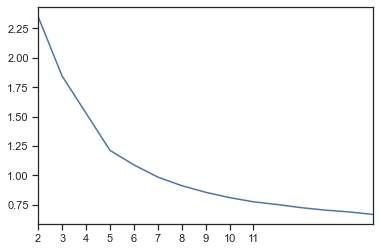

In [305]:
wyniki = pd.Series(count_wcss_scores(average_sentiments, 15))
wyniki.index += 2
plt = wyniki.plot.line(xticks = list(range(2, 12)))
plt

In [306]:
import copy
wcss_scores = {}
sillhoute_scores = {}
for m in list(models.keys()):
    wcss_scores[m] = []
    sillhoute_scores[m] = []
for s in sc_scores:
    for m in list(models.keys()):
        wcss_scores[m].append(s.loc[m].iloc[0])
        sillhoute_scores[m].append(s.loc[m].iloc[1])
    
for m in list(models.keys()):
    wcss_scores[m] = pd.Series(wcss_scores[m])
    sillhoute_scores[m] = pd.Series(sillhoute_scores[m])
    wcss_scores[m].index += 2
    sillhoute_scores[m].index += 2
wcss_scores = pd.DataFrame.from_dict(wcss_scores)
sillhoute_scores = pd.DataFrame.from_dict(sillhoute_scores)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBF23B87F0>,
      dtype=object)

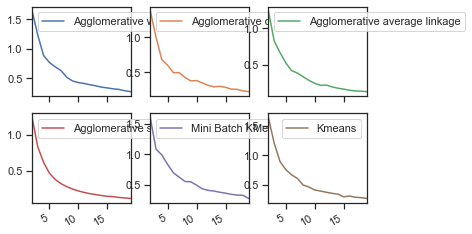

In [307]:
import warnings
warnings.filterwarnings('ignore')
wcss_scores.plot.line(subplots=True, legend=True, layout=(2, 3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBF2555668>,
      dtype=object)

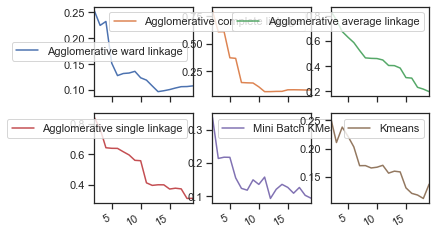

In [308]:
import warnings
warnings.filterwarnings('ignore')
sillhoute_scores.plot.line(subplots=True, legend=True, layout=(2, 3))

## Zabarwienie emocjonalne klastrów
### k = 8

In [291]:
from sklearn import preprocessing

x = average_sentiments.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
average_sentiments2 = pd.DataFrame(x_scaled)

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 8)
etykiety = model.fit_predict(average_sentiments2)
tmp = average_sentiments.iloc[np.where(etykiety==0)]
tmp = tmp.sum()/tmp.shape[0]
cluster_emotions = pd.DataFrame(copy.copy([tmp])) 
for i in range(1, 8):
    tmp = average_sentiments.iloc[np.where(etykiety==i)]
    tmp = tmp.sum()/tmp.shape[0]
    cluster_emotions = cluster_emotions.append(copy.copy([tmp]))

Text(0.5, 1.0, 'Cluster nr 7 - 1 elementów')

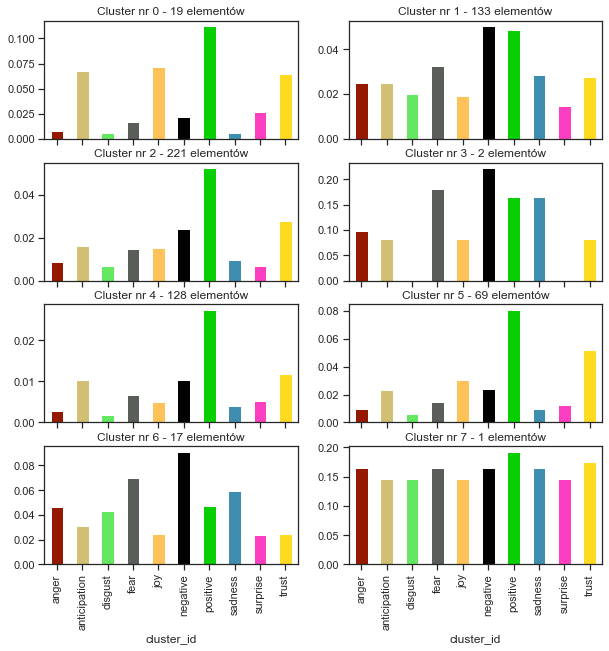

In [292]:
warnings.filterwarnings('ignore')
cluster_emotions = cluster_emotions.rename_axis('cluster_id', axis='columns')
cluster_emotions.index = list(range(0, 8))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10), sharex=True)
colors = ['#941900', '#d1bf73', '#64e861', '#595e59', '#ffc259', '#030202', '#07cf00', '#3f8eb0', '#fc3fc0', '#ffda21']
labels_series = pd.Series(labels)

cluster_emotions.iloc[0].plot.bar(ax=axes[0, 0], \
                                  color = colors).set_title('Cluster nr 0 - ' + \
                                  str(len(labels_series.iloc[np.where(etykiety==0)])) + ' elementów')
cluster_emotions.iloc[1].plot.bar(ax=axes[0, 1], \
                                  color = colors).set_title('Cluster nr 1 - ' + \
                                  str(len(labels_series.iloc[np.where(etykiety==1)])) + ' elementów')
cluster_emotions.iloc[2].plot.bar(ax=axes[1, 0], \
                                  color = colors).set_title('Cluster nr 2 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==2)])) + ' elementów')
cluster_emotions.iloc[3].plot.bar(ax=axes[1, 1], \
                                  color = colors).set_title('Cluster nr 3 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==3)])) + ' elementów')
cluster_emotions.iloc[4].plot.bar(ax=axes[2, 0], \
                                  color = colors).set_title('Cluster nr 4 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==4)])) + ' elementów')
cluster_emotions.iloc[5].plot.bar(ax=axes[2, 1], \
                                  color = colors).set_title('Cluster nr 5 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==5)])) + ' elementów')
cluster_emotions.iloc[6].plot.bar(ax=axes[3, 0], \
                                  color = colors).set_title('Cluster nr 6 - ' + \
                                str(len(labels_series.iloc[np.where(etykiety==6)])) + ' elementów')
cluster_emotions.iloc[7].plot.bar(ax=axes[3, 1], \
                                  color = colors).set_title('Cluster nr 7 - ' + \
                                 str(len(labels_series.iloc[np.where(etykiety==7)])) + ' elementów')

## Co jest gdzie (czyli labels) ?

### k = 8

In [293]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==0)])

['Buddhism_Ch17',
 'Upanishad_Ch13',
 'Upanishad_Ch18',
 'Upanishad_Ch19',
 'Upanishad_Ch30',
 'Upanishad_Ch34',
 'Upanishad_Ch44',
 'Upanishad_Ch45',
 'Upanishad_Ch46',
 'Upanishad_Ch47',
 'Upanishad_Ch62',
 'Upanishad_Ch78',
 'YogaSutra_Ch14',
 'YogaSutra_Ch19',
 'YogaSutra_Ch46',
 'YogaSutra_Ch63',
 'YogaSutra_Ch84',
 'YogaSutra_Ch126',
 'YogaSutra_Ch128']

In [294]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==1)])

['Buddhism_Ch7',
 'Buddhism_Ch15',
 'Buddhism_Ch16',
 'Buddhism_Ch21',
 'Buddhism_Ch23',
 'Buddhism_Ch24',
 'Buddhism_Ch33',
 'Buddhism_Ch37',
 'Buddhism_Ch38',
 'Buddhism_Ch44',
 'TaoTeChing_Ch8',
 'TaoTeChing_Ch9',
 'TaoTeChing_Ch12',
 'TaoTeChing_Ch13',
 'TaoTeChing_Ch16',
 'TaoTeChing_Ch23',
 'TaoTeChing_Ch31',
 'TaoTeChing_Ch35',
 'TaoTeChing_Ch38',
 'TaoTeChing_Ch42',
 'TaoTeChing_Ch45',
 'TaoTeChing_Ch50',
 'TaoTeChing_Ch55',
 'TaoTeChing_Ch58',
 'TaoTeChing_Ch60',
 'TaoTeChing_Ch69',
 'TaoTeChing_Ch73',
 'TaoTeChing_Ch75',
 'TaoTeChing_Ch76',
 'Upanishad_Ch3',
 'Upanishad_Ch7',
 'Upanishad_Ch11',
 'Upanishad_Ch27',
 'Upanishad_Ch28',
 'Upanishad_Ch35',
 'Upanishad_Ch37',
 'Upanishad_Ch42',
 'Upanishad_Ch48',
 'Upanishad_Ch51',
 'Upanishad_Ch57',
 'Upanishad_Ch64',
 'Upanishad_Ch69',
 'Upanishad_Ch71',
 'Upanishad_Ch77',
 'Upanishad_Ch83',
 'Upanishad_Ch87',
 'Upanishad_Ch96',
 'Upanishad_Ch105',
 'Upanishad_Ch110',
 'Upanishad_Ch114',
 'Upanishad_Ch141',
 'Upanishad_Ch160',
 'U

In [298]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==2)])

['Buddhism_Ch1',
 'Buddhism_Ch3',
 'Buddhism_Ch5',
 'Buddhism_Ch8',
 'Buddhism_Ch19',
 'Buddhism_Ch20',
 'Buddhism_Ch25',
 'Buddhism_Ch27',
 'Buddhism_Ch30',
 'Buddhism_Ch34',
 'Buddhism_Ch39',
 'Buddhism_Ch41',
 'Buddhism_Ch42',
 'Buddhism_Ch45',
 'Buddhism_Ch46',
 'TaoTeChing_Ch2',
 'TaoTeChing_Ch3',
 'TaoTeChing_Ch5',
 'TaoTeChing_Ch6',
 'TaoTeChing_Ch7',
 'TaoTeChing_Ch10',
 'TaoTeChing_Ch15',
 'TaoTeChing_Ch17',
 'TaoTeChing_Ch20',
 'TaoTeChing_Ch22',
 'TaoTeChing_Ch26',
 'TaoTeChing_Ch27',
 'TaoTeChing_Ch29',
 'TaoTeChing_Ch32',
 'TaoTeChing_Ch33',
 'TaoTeChing_Ch34',
 'TaoTeChing_Ch40',
 'TaoTeChing_Ch41',
 'TaoTeChing_Ch46',
 'TaoTeChing_Ch51',
 'TaoTeChing_Ch53',
 'TaoTeChing_Ch57',
 'TaoTeChing_Ch59',
 'TaoTeChing_Ch61',
 'TaoTeChing_Ch63',
 'TaoTeChing_Ch64',
 'TaoTeChing_Ch66',
 'TaoTeChing_Ch68',
 'TaoTeChing_Ch70',
 'TaoTeChing_Ch72',
 'TaoTeChing_Ch78',
 'TaoTeChing_Ch79',
 'TaoTeChing_Ch80',
 'TaoTeChing_Ch81',
 'Upanishad_Ch2',
 'Upanishad_Ch14',
 'Upanishad_Ch16',
 'U

In [299]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==3)])

['Upanishad_Ch9', 'Upanishad_Ch12']

In [300]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==4)])

['Buddhism_Ch2',
 'Buddhism_Ch9',
 'Buddhism_Ch10',
 'Buddhism_Ch11',
 'Buddhism_Ch13',
 'Buddhism_Ch14',
 'Buddhism_Ch22',
 'Buddhism_Ch26',
 'Buddhism_Ch28',
 'Buddhism_Ch31',
 'Buddhism_Ch35',
 'Buddhism_Ch36',
 'Buddhism_Ch40',
 'Buddhism_Ch43',
 'TaoTeChing_Ch1',
 'TaoTeChing_Ch4',
 'TaoTeChing_Ch11',
 'TaoTeChing_Ch14',
 'TaoTeChing_Ch21',
 'TaoTeChing_Ch24',
 'TaoTeChing_Ch25',
 'TaoTeChing_Ch36',
 'TaoTeChing_Ch37',
 'TaoTeChing_Ch39',
 'TaoTeChing_Ch43',
 'TaoTeChing_Ch47',
 'TaoTeChing_Ch48',
 'TaoTeChing_Ch54',
 'TaoTeChing_Ch56',
 'TaoTeChing_Ch77',
 'Upanishad_Ch4',
 'Upanishad_Ch5',
 'Upanishad_Ch6',
 'Upanishad_Ch10',
 'Upanishad_Ch15',
 'Upanishad_Ch26',
 'Upanishad_Ch32',
 'Upanishad_Ch33',
 'Upanishad_Ch38',
 'Upanishad_Ch40',
 'Upanishad_Ch55',
 'Upanishad_Ch59',
 'Upanishad_Ch60',
 'Upanishad_Ch61',
 'Upanishad_Ch79',
 'Upanishad_Ch80',
 'Upanishad_Ch85',
 'Upanishad_Ch89',
 'Upanishad_Ch91',
 'Upanishad_Ch92',
 'Upanishad_Ch97',
 'Upanishad_Ch99',
 'Upanishad_Ch101

In [301]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==5)])

['Buddhism_Ch4',
 'Buddhism_Ch29',
 'Buddhism_Ch32',
 'TaoTeChing_Ch18',
 'TaoTeChing_Ch19',
 'TaoTeChing_Ch28',
 'TaoTeChing_Ch30',
 'TaoTeChing_Ch49',
 'TaoTeChing_Ch52',
 'TaoTeChing_Ch62',
 'TaoTeChing_Ch65',
 'TaoTeChing_Ch67',
 'Upanishad_Ch1',
 'Upanishad_Ch8',
 'Upanishad_Ch22',
 'Upanishad_Ch43',
 'Upanishad_Ch52',
 'Upanishad_Ch54',
 'Upanishad_Ch75',
 'Upanishad_Ch94',
 'Upanishad_Ch106',
 'Upanishad_Ch112',
 'Upanishad_Ch113',
 'Upanishad_Ch118',
 'Upanishad_Ch123',
 'Upanishad_Ch134',
 'Upanishad_Ch158',
 'Upanishad_Ch159',
 'YogaSutra_Ch13',
 'YogaSutra_Ch15',
 'YogaSutra_Ch20',
 'YogaSutra_Ch21',
 'YogaSutra_Ch35',
 'YogaSutra_Ch38',
 'YogaSutra_Ch44',
 'YogaSutra_Ch47',
 'YogaSutra_Ch59',
 'YogaSutra_Ch60',
 'YogaSutra_Ch62',
 'YogaSutra_Ch75',
 'YogaSutra_Ch91',
 'YogaSutra_Ch93',
 'YogaSutra_Ch94',
 'YogaSutra_Ch109',
 'YogaSutra_Ch125',
 'YogaSutra_Ch127',
 'YogaSutra_Ch135',
 'YogaSutra_Ch138',
 'YogaSutra_Ch168',
 'YogaSutra_Ch179',
 'YogaSutra_Ch184',
 'BookOfProv

In [302]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==6)])

['Buddhism_Ch6',
 'Buddhism_Ch18',
 'TaoTeChing_Ch44',
 'TaoTeChing_Ch71',
 'TaoTeChing_Ch74',
 'Upanishad_Ch29',
 'Upanishad_Ch67',
 'Upanishad_Ch74',
 'Upanishad_Ch76',
 'Upanishad_Ch95',
 'Upanishad_Ch161',
 'YogaSutra_Ch57',
 'YogaSutra_Ch61',
 'YogaSutra_Ch71',
 'YogaSutra_Ch82',
 'YogaSutra_Ch151',
 'YogaSutra_Ch186']

In [303]:
labels_series = pd.Series(labels)
list(labels_series.iloc[np.where(etykiety==7)])

['Buddhism_Ch12']